# PyMapAccuracy Tutorial: Thematic Map Accuracy Assessment

This tutorial demonstrates how to use the **PyMapAccuracy** package for rigorous thematic map accuracy assessment using stratified sampling estimators.

##  Background

Thematic map accuracy assessment requires proper statistical methods to account for sampling design and provide unbiased estimates with appropriate uncertainty quantification. This package implements two key approaches:

- **Stehman (2014)**: When sampling strata differ from map classes
- **Olofsson et al. (2014)**: When map classes serve as sampling strata

##  Learning Objectives

By the end of this tutorial, you'll understand:
1. When to use each estimator
2. How to prepare your data
3. How to interpret the results
4. How to report accuracy metrics with proper uncertainty

##  Setup and Installation

First, let's import the necessary libraries and set up our environment.

In [ ]:
# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import PyMapAccuracy estimators
from src.pymapaccuracy.estimators import olofsson, stehman2014

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

✅ Setup complete! Ready to assess map accuracy.


##  Example 1: Olofsson Estimator (Standard Approach)

### Scenario: Land Cover Mapping with Map-Class Stratified Sampling

In this example, we assess a land cover map where:
- **Sampling strata = Map classes** (forest, grassland, water, urban)
- Samples were allocated proportionally within each map class
- This is the **standard approach** for map accuracy assessment

In [2]:
# === SCENARIO 1: Standard Map Accuracy Assessment ===

print(" SCENARIO 1: Land Cover Map Assessment")
print("=" * 50)

# Define land cover classes
lc_classes = ['forest', 'grassland', 'water', 'urban']

# Create realistic reference and map data
n_samples = 200

# Generate reference data with realistic class distribution
reference_probs = [0.45, 0.30, 0.15, 0.10]  # Forest-dominated landscape
reference = np.random.choice(lc_classes, size=n_samples, p=reference_probs)

# Generate map predictions with class-specific accuracies
map_pred = reference.copy()
class_errors = {
    'forest': 0.15,      # 85% accuracy
    'grassland': 0.20,   # 80% accuracy
    'water': 0.05,       # 95% accuracy (easy to detect)
    'urban': 0.25        # 75% accuracy (mixed with other classes)
}

# Add realistic classification errors
for i, true_class in enumerate(reference):
    if np.random.random() < class_errors[true_class]:
        # Misclassify to a different class
        other_classes = [c for c in lc_classes if c != true_class]
        map_pred[i] = np.random.choice(other_classes)

# Convert to lists for the estimator
reference = reference.tolist()
map_pred = map_pred.tolist()

# Define map class areas (population sizes) in hectares
map_areas = {
    'forest': 18000.0,
    'grassland': 12000.0,
    'water': 6000.0,
    'urban': 4000.0
}

total_area = sum(map_areas.values())

print(" Dataset Summary:")
print(f" Total samples: {len(reference)}")
print(f" Land cover classes: {lc_classes}")
print(f" Total study area: {total_area:,} hectares")
print(" Sampling design: Stratified by map classes")

# Show sample distribution
sample_dist = pd.Series(map_pred).value_counts().sort_index()
print("Sample distribution by map class:")
for class_name, count in sample_dist.items():
    pct = 100 * count / len(map_pred)
    area_pct = 100 * map_areas[class_name] / total_area
    print(f"   • {class_name:>10}: {count:3d} samples ({pct:4.1f}% of samples, {area_pct:4.1f}% of area)")

 SCENARIO 1: Land Cover Map Assessment
 Dataset Summary:
 Total samples: 200
 Land cover classes: ['forest', 'grassland', 'water', 'urban']
 Total study area: 40,000.0 hectares
 Sampling design: Stratified by map classes
Sample distribution by map class:
   •     forest:  82 samples (41.0% of samples, 45.0% of area)
   •  grassland:  52 samples (26.0% of samples, 30.0% of area)
   •      urban:  26 samples (13.0% of samples, 10.0% of area)
   •      water:  40 samples (20.0% of samples, 15.0% of area)


In [3]:
# Run Olofsson estimator
print("\n🔍 Running Olofsson Estimator...")
olofsson_results = olofsson(reference, map_pred, map_areas)

print(" Analysis complete!")
print("\n" + "=" * 60)
print(" OLOFSSON ESTIMATOR RESULTS")
print("=" * 60)

# Overall Accuracy
oa = olofsson_results['OA']
se_oa = olofsson_results['SEoa']
ci_oa = olofsson_results['CIoa']

print(" Overall Accuracy:")
print(f" Estimate: {oa:.3f} ({oa*100:.1f}%)")
print(f" Standard Error: {se_oa:.4f}")
print(f" 95% Confidence Interval: [{ci_oa[0]:.3f}, {ci_oa[1]:.3f}]")
print(f" Margin of Error: ±{(ci_oa[1] - ci_oa[0])/2:.3f}")

# User's and Producer's Accuracies
print("Class-specific Accuracies:")
ua = olofsson_results['UA']
pa = olofsson_results['PA']
se_ua = olofsson_results['SEua']
se_pa = olofsson_results['SEpa']

print(f"{'Class':>10} {'User\'s Acc':>12} {'SE(UA)':>8} {'Producer\'s Acc':>15} {'SE(PA)':>8}")
print("-" * 65)
for class_name in sorted(lc_classes):
    if class_name in ua.index and class_name in pa.index:
        print(f"{class_name:>10} {ua[class_name]:>9.3f} {se_ua[class_name]:>8.4f} {pa[class_name]:>12.3f} {se_pa[class_name]:>8.4f}")

# Area estimates
area_est = olofsson_results['area']
se_area = olofsson_results['SEa']

print("Area Estimates:")
print(f"{'Class':>10} {'Estimated %':>12} {'SE(Area)':>10} {'Hectares':>12}")
print("-" * 50)
for class_name in sorted(lc_classes):
    if class_name in area_est.index:
        pct = area_est[class_name] * 100
        hectares = area_est[class_name] * total_area
        se_pct = se_area[class_name] * 100
        print(f"{class_name:>10} {pct:>9.1f}% {se_pct:>9.2f}% {hectares:>9.0f} ha")


🔍 Running Olofsson Estimator...
 Analysis complete!

 OLOFSSON ESTIMATOR RESULTS
 Overall Accuracy:
 Estimate: 0.845 (84.5%)
 Standard Error: 0.0245
 95% Confidence Interval: [0.797, 0.893]
 Margin of Error: ±0.048
Class-specific Accuracies:
     Class   User's Acc   SE(UA)  Producer's Acc   SE(PA)
-----------------------------------------------------------------
    forest     0.939   0.0266        0.834   0.0304
 grassland     0.827   0.0530        0.842   0.0422
     urban     0.615   0.0973        0.823   0.0887
     water     0.750   0.0693        0.907   0.0596
Area Estimates:
     Class  Estimated %   SE(Area)     Hectares
--------------------------------------------------
    forest      50.7%      2.19%     20260 ha
 grassland      29.5%      2.15%     11786 ha
     urban       7.5%      1.25%      2992 ha
     water      12.4%      1.32%      4962 ha


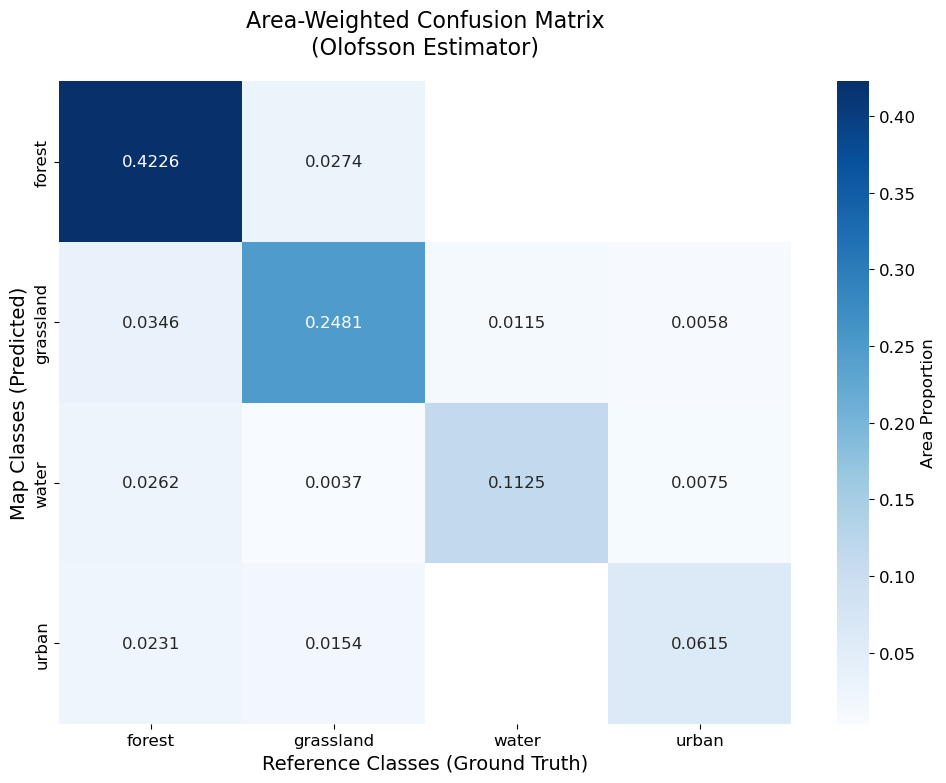

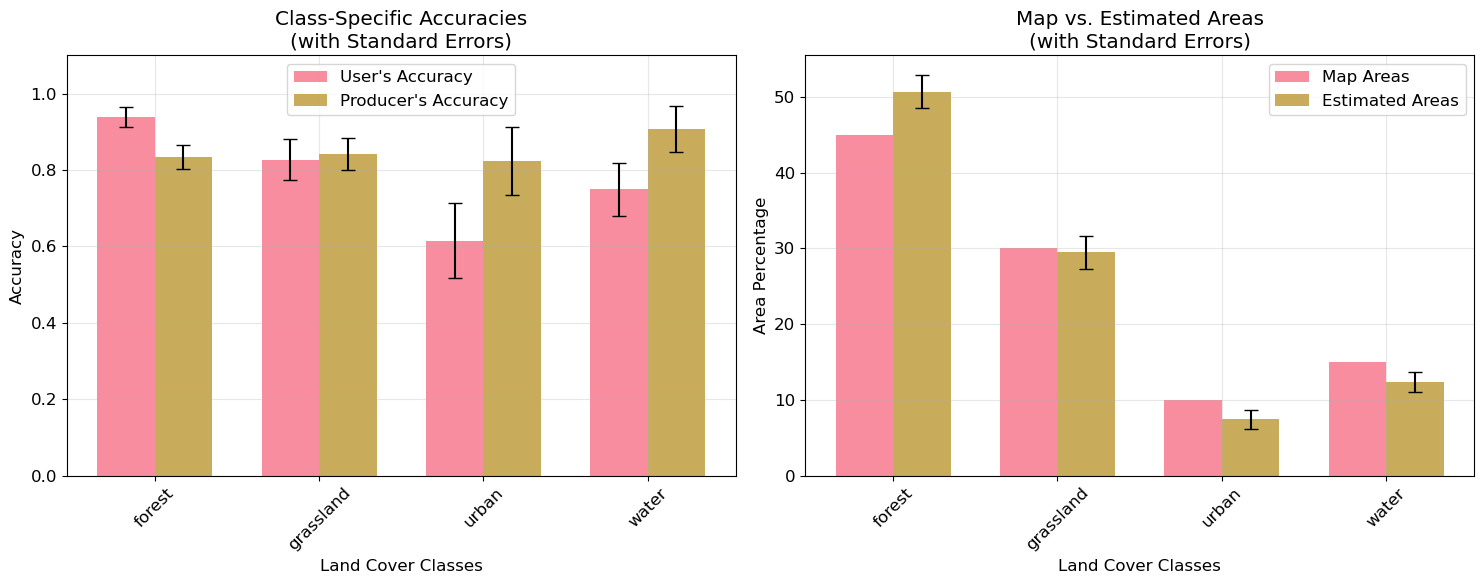

In [4]:
# Visualize the confusion matrix
matrix = olofsson_results['matrix']

# Remove margins for cleaner visualization
if 'sum' in matrix.index:
    matrix_clean = matrix.drop('sum', axis=0).drop('sum', axis=1)
else:
    matrix_clean = matrix.copy()

# Create confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_clean, annot=True, fmt='.4f', cmap='Blues',
            cbar_kws={'label': 'Area Proportion'})
plt.title('Area-Weighted Confusion Matrix\n(Olofsson Estimator)', fontsize=16, pad=20)
plt.xlabel('Reference Classes (Ground Truth)', fontsize=14)
plt.ylabel('Map Classes (Predicted)', fontsize=14)
plt.tight_layout()
plt.show()

# Create accuracy comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# User's vs Producer's Accuracy
classes_plot = [c for c in sorted(lc_classes) if c in ua.index and c in pa.index]
ua_vals = [ua[c] for c in classes_plot]
pa_vals = [pa[c] for c in classes_plot]
se_ua_vals = [se_ua[c] for c in classes_plot]
se_pa_vals = [se_pa[c] for c in classes_plot]

x = np.arange(len(classes_plot))
width = 0.35

ax1.bar(x - width/2, ua_vals, width, label="User's Accuracy",
        yerr=se_ua_vals, capsize=5, alpha=0.8)
ax1.bar(x + width/2, pa_vals, width, label="Producer's Accuracy",
        yerr=se_pa_vals, capsize=5, alpha=0.8)

ax1.set_xlabel('Land Cover Classes')
ax1.set_ylabel('Accuracy')
ax1.set_title('Class-Specific Accuracies\n(with Standard Errors)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes_plot, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)

# Area estimates comparison
area_est_vals = [area_est[c] * 100 for c in classes_plot]
se_area_vals = [se_area[c] * 100 for c in classes_plot]
map_area_vals = [map_areas[c] / total_area * 100 for c in classes_plot]

ax2.bar(x - width/2, map_area_vals, width, label='Map Areas', alpha=0.8)
ax2.bar(x + width/2, area_est_vals, width, label='Estimated Areas',
        yerr=se_area_vals, capsize=5, alpha=0.8)

ax2.set_xlabel('Land Cover Classes')
ax2.set_ylabel('Area Percentage')
ax2.set_title('Map vs. Estimated Areas\n(with Standard Errors)')
ax2.set_xticks(x)
ax2.set_xticklabels(classes_plot, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  Example 2: Stehman Estimator (Complex Stratification)

### Scenario: Regional Forest Change Assessment

In this example, we assess a forest change map where:
- **Sampling strata = Administrative regions** (different from map classes)
- **Map classes = Change types** (stable forest, deforestation, afforestation, stable non-forest)
- This requires the **Stehman (2014) estimator** because strata ≠ map classes

In [5]:
# === SCENARIO 2: Forest Change Assessment with Administrative Stratification ===

print(" SCENARIO 2: Forest Change Map Assessment")
print("=" * 50)

# Define change classes and administrative regions
change_classes = ['stable_forest', 'deforestation', 'afforestation', 'stable_nonforest']
admin_regions = ['region_A', 'region_B', 'region_C', 'region_D']

# Create stratified sample data
n_samples = 300

# Assign samples to administrative regions (strata)
strata = np.random.choice(admin_regions, size=n_samples, p=[0.3, 0.25, 0.25, 0.2])

# Generate reference data with region-specific change patterns
reference = []
map_pred = []

region_change_probs = {
    'region_A': [0.6, 0.15, 0.1, 0.15],   # High forest stability
    'region_B': [0.4, 0.3, 0.05, 0.25],   # High deforestation
    'region_C': [0.3, 0.1, 0.3, 0.3],     # High afforestation
    'region_D': [0.2, 0.05, 0.05, 0.7]    # Mostly stable non-forest
}

# Generate realistic reference and map data for each region
for stratum in strata:
    # Reference class based on region-specific probabilities
    ref_class = np.random.choice(change_classes, p=region_change_probs[stratum])
    reference.append(ref_class)

    # Map prediction with some classification errors
    if np.random.random() < 0.85:  # 85% overall accuracy
        map_class = ref_class
    else:
        # Realistic confusion patterns
        if ref_class == 'stable_forest':
            map_class = np.random.choice(['deforestation', 'stable_nonforest'])
        elif ref_class == 'deforestation':
            map_class = np.random.choice(['stable_forest', 'stable_nonforest'])
        elif ref_class == 'afforestation':
            map_class = np.random.choice(['stable_forest', 'stable_nonforest'])
        else:  # stable_nonforest
            map_class = np.random.choice(['stable_forest', 'afforestation'])

    map_pred.append(map_class)

# Convert to lists
strata = strata.tolist()

# Define administrative region areas (population sizes)
region_areas = {
    'region_A': 25000.0,
    'region_B': 20000.0,
    'region_C': 18000.0,
    'region_D': 22000.0
}

total_study_area = sum(region_areas.values())

print("📊 Dataset Summary:")
print(f"   • Total samples: {len(reference)}")
print(f"   • Change classes: {change_classes}")
print(f"   • Administrative regions: {admin_regions}")
print(f"   • Total study area: {total_study_area:,} hectares")
print("   • Sampling design: Stratified by administrative regions")

# Show sample distribution by strata and map classes
strata_dist = pd.Series(strata).value_counts().sort_index()
print("\n📈 Sample distribution by administrative region:")
for region, count in strata_dist.items():
    pct = 100 * count / len(strata)
    area_pct = 100 * region_areas[region] / total_study_area
    print(f"   • {region:>9}: {count:3d} samples ({pct:4.1f}% of samples, {area_pct:4.1f}% of area)")

map_dist = pd.Series(map_pred).value_counts().sort_index()
print("\n🗺️ Sample distribution by map class:")
for change_type, count in map_dist.items():
    pct = 100 * count / len(map_pred)
    print(f"   • {change_type:>18}: {count:3d} samples ({pct:4.1f}%)")

 SCENARIO 2: Forest Change Map Assessment
📊 Dataset Summary:
   • Total samples: 300
   • Change classes: ['stable_forest', 'deforestation', 'afforestation', 'stable_nonforest']
   • Administrative regions: ['region_A', 'region_B', 'region_C', 'region_D']
   • Total study area: 85,000.0 hectares
   • Sampling design: Stratified by administrative regions

📈 Sample distribution by administrative region:
   •  region_A:  98 samples (32.7% of samples, 29.4% of area)
   •  region_B:  73 samples (24.3% of samples, 23.5% of area)
   •  region_C:  66 samples (22.0% of samples, 21.2% of area)
   •  region_D:  63 samples (21.0% of samples, 25.9% of area)

🗺️ Sample distribution by map class:
   •      afforestation:  46 samples (15.3%)
   •      deforestation:  51 samples (17.0%)
   •      stable_forest: 101 samples (33.7%)
   •   stable_nonforest: 102 samples (34.0%)


In [ ]:
# Run Stehman estimator
print(" Running Stehman Estimator...")
stehman_results = stehman2014(strata, reference, map_pred, region_areas)

print("Analysis complete!")
print("\n" + "=" * 60)
print(" STEHMAN ESTIMATOR RESULTS")
print("=" * 60)

# Overall Accuracy
oa_s = stehman_results['OA']
se_oa_s = stehman_results['SEoa']
ci_oa_s = stehman_results['CIoa']

print("Overall Accuracy:")
print(f"   • Estimate: {oa_s:.3f} ({oa_s*100:.1f}%)")
print(f"   • Standard Error: {se_oa_s:.4f}")
print(f"   • 95% Confidence Interval: [{ci_oa_s[0]:.3f}, {ci_oa_s[1]:.3f}]")
print(f"   • Margin of Error: ±{(ci_oa_s[1] - ci_oa_s[0])/2:.3f}")

# Class-specific accuracies
ua_s = stehman_results['UA']
pa_s = stehman_results['PA']
se_ua_s = stehman_results['SEua']
se_pa_s = stehman_results['SEpa']

print("Class-specific Accuracies:")
print(f"{'Change Class':>18} {'User Acc':>12} {'SE(UA)':>8} {'Producer Acc':>15} {'SE(PA)':>8}")
print("-" * 75)
for class_name in sorted(change_classes):
    if class_name in ua_s.index and class_name in pa_s.index:
        print(f"{class_name:>18} {ua_s[class_name]:>9.3f} {se_ua_s[class_name]:>8.4f} {pa_s[class_name]:>12.3f} {se_pa_s[class_name]:>8.4f}")

# Area estimates
area_est_s = stehman_results['area']
se_area_s = stehman_results['SEa']

print(" Area Estimates:")
print(f"{'Change Class':>18} {'Estimated %':>12} {'SE(Area)':>10} {'Hectares':>12}")
print("-" * 60)
for class_name in sorted(change_classes):
    if class_name in area_est_s.index:
        pct = area_est_s[class_name] * 100
        hectares = area_est_s[class_name] * total_study_area
        se_pct = se_area_s[class_name] * 100
        print(f"{class_name:>18} {pct:>9.1f}% {se_pct:>9.2f}% {hectares:>9.0f} ha")

 Running Stehman Estimator...
Analysis complete!

 STEHMAN ESTIMATOR RESULTS
Overall Accuracy:
   • Estimate: 0.846 (84.6%)
   • Standard Error: 0.0207
   • 95% Confidence Interval: [0.806, 0.887]
   • Margin of Error: ±0.041
Class-specific Accuracies:
      Change Class   User's Acc   SE(UA)  Producer's Acc   SE(PA)
---------------------------------------------------------------------------
     afforestation     0.803   0.0592        0.904   0.0460
     deforestation     0.791   0.0562        0.833   0.0541
     stable_forest     0.874   0.0336        0.810   0.0375
  stable_nonforest     0.865   0.0322        0.867   0.0334
 Area Estimates:
      Change Class  Estimated %   SE(Area)     Hectares
------------------------------------------------------------
     afforestation      13.3%      1.85%     11335 ha
     deforestation      15.8%      2.05%     13462 ha
     stable_forest      35.2%      2.56%     29925 ha
  stable_nonforest      35.6%      2.64%     30277 ha


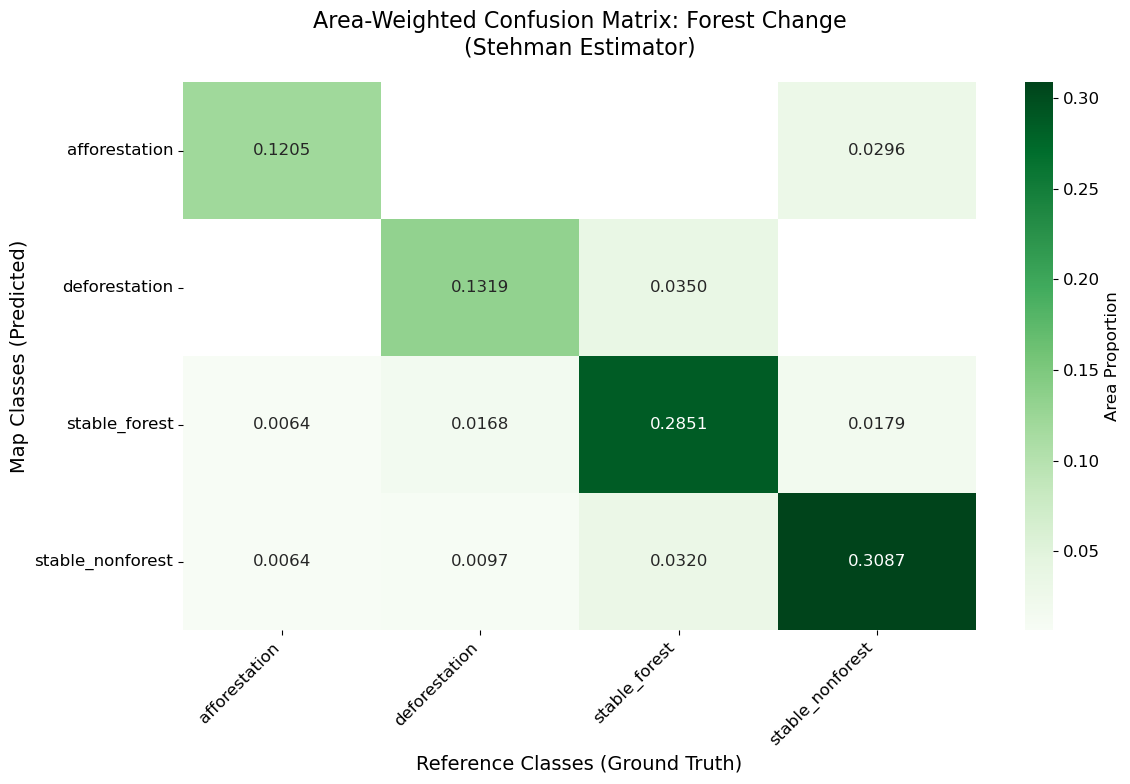

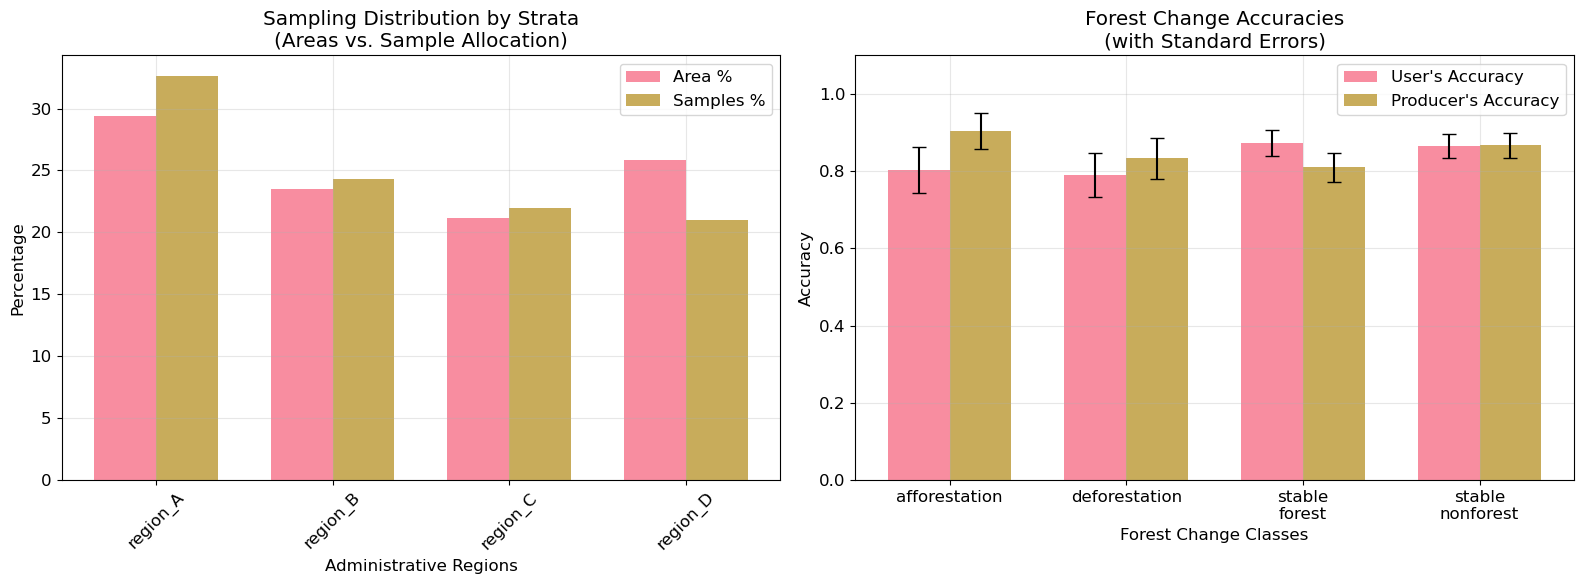

In [7]:
# Visualize Stehman results
matrix_s = stehman_results['matrix']

# Remove margins for cleaner visualization
if 'sum' in matrix_s.index:
    matrix_s_clean = matrix_s.drop('sum', axis=0).drop('sum', axis=1)
else:
    matrix_s_clean = matrix_s.copy()

# Create forest change confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_s_clean, annot=True, fmt='.4f', cmap='Greens',
            cbar_kws={'label': 'Area Proportion'})
plt.title('Area-Weighted Confusion Matrix: Forest Change\n(Stehman Estimator)', fontsize=16, pad=20)
plt.xlabel('Reference Classes (Ground Truth)', fontsize=14)
plt.ylabel('Map Classes (Predicted)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Compare sampling distribution across strata
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Strata sample distribution
strata_counts = pd.Series(strata).value_counts().sort_index()
strata_areas_pct = [region_areas[r] / total_study_area * 100 for r in strata_counts.index]
strata_samples_pct = [count / len(strata) * 100 for count in strata_counts.values]

x = np.arange(len(strata_counts))
width = 0.35

ax1.bar(x - width/2, strata_areas_pct, width, label='Area %', alpha=0.8)
ax1.bar(x + width/2, strata_samples_pct, width, label='Samples %', alpha=0.8)

ax1.set_xlabel('Administrative Regions')
ax1.set_ylabel('Percentage')
ax1.set_title('Sampling Distribution by Strata\n(Areas vs. Sample Allocation)')
ax1.set_xticks(x)
ax1.set_xticklabels(strata_counts.index, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Change class accuracies
change_classes_plot = [c for c in sorted(change_classes) if c in ua_s.index and c in pa_s.index]
ua_s_vals = [ua_s[c] for c in change_classes_plot]
pa_s_vals = [pa_s[c] for c in change_classes_plot]
se_ua_s_vals = [se_ua_s[c] for c in change_classes_plot]
se_pa_s_vals = [se_pa_s[c] for c in change_classes_plot]

x2 = np.arange(len(change_classes_plot))

ax2.bar(x2 - width/2, ua_s_vals, width, label="User's Accuracy",
        yerr=se_ua_s_vals, capsize=5, alpha=0.8)
ax2.bar(x2 + width/2, pa_s_vals, width, label="Producer's Accuracy",
        yerr=se_pa_s_vals, capsize=5, alpha=0.8)

ax2.set_xlabel('Forest Change Classes')
ax2.set_ylabel('Accuracy')
ax2.set_title('Forest Change Accuracies\n(with Standard Errors)')
ax2.set_xticks(x2)
ax2.set_xticklabels([c.replace('_', '\n') for c in change_classes_plot], rotation=0, ha='center')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

##  Comparison: When Methods Should Give Similar Results

Let's test the theoretical equivalence of both estimators when using **identical sampling designs**.

In [8]:
# === THEORETICAL EQUIVALENCE TEST ===

print("EQUIVALENCE TEST: Same Sampling Design")
print("=" * 50)

# Create test data where strata = map classes for both estimators
test_classes = ['forest', 'agriculture', 'urban']
n_test = 150

# Generate test reference data
test_reference = np.random.choice(test_classes, size=n_test, p=[0.5, 0.35, 0.15]).tolist()

# Generate test map data with some errors
test_map = test_reference.copy()
error_indices = np.random.choice(n_test, size=int(0.2 * n_test), replace=False)
for idx in error_indices:
    other_classes = [c for c in test_classes if c != test_map[idx]]
    test_map[idx] = np.random.choice(other_classes)

# Use map classes as strata (making designs identical)
test_strata = test_map.copy()

# Define identical class areas
test_areas = {
    'forest': 12000.0,
    'agriculture': 8000.0,
    'urban': 3000.0
}

print("Test setup:")
print(f"   • Samples: {n_test}")
print(f"   • Classes: {test_classes}")
print("   • Design: Map classes = Strata (identical for both estimators)")

# Run both estimators
olof_test = olofsson(test_reference, test_map, test_areas)
steh_test = stehman2014(test_strata, test_reference, test_map, test_areas)

print(" Comparison Results:")
print(f"{'Metric':<20} {'Olofsson':<12} {'Stehman':<12} {'Difference':<12}")
print("-" * 65)

# Overall Accuracy
oa_diff = abs(olof_test['OA'] - steh_test['OA'])
print(f"{'Overall Accuracy':<20} {olof_test['OA']:<12.6f} {steh_test['OA']:<12.6f} {oa_diff:<12.2e}")

# Standard Error of OA
se_oa_diff = abs(olof_test['SEoa'] - steh_test['SEoa'])
print(f"{'SE(OA)':<20} {olof_test['SEoa']:<12.6f} {steh_test['SEoa']:<12.6f} {se_oa_diff:<12.2e}")

print(" Class-specific comparisons:")
for class_name in test_classes:
    if class_name in olof_test['UA'].index and class_name in steh_test['UA'].index:
        ua_diff = abs(olof_test['UA'][class_name] - steh_test['UA'][class_name])
        pa_diff = abs(olof_test['PA'][class_name] - steh_test['PA'][class_name])
        area_diff = abs(olof_test['area'][class_name] - steh_test['area'][class_name])

        print(f"\n{class_name} Class:")
        print(f"   • UA difference: {ua_diff:.2e}")
        print(f"   • PA difference: {pa_diff:.2e}")
        print(f"   • Area difference: {area_diff:.2e}")

print(" Conclusion: When sampling designs are identical, both estimators")
print("   produce nearly identical results (differences < 1e-10 are numerical precision).")

EQUIVALENCE TEST: Same Sampling Design
Test setup:
   • Samples: 150
   • Classes: ['forest', 'agriculture', 'urban']
   • Design: Map classes = Strata (identical for both estimators)
 Comparison Results:
Metric               Olofsson     Stehman      Difference  
-----------------------------------------------------------------
Overall Accuracy     0.818373     0.818373     1.11e-16    
SE(OA)               0.029655     0.029554     1.01e-04    
 Class-specific comparisons:

forest Class:
   • UA difference: 0.00e+00
   • PA difference: 0.00e+00
   • Area difference: 0.00e+00

agriculture Class:
   • UA difference: 0.00e+00
   • PA difference: 1.11e-16
   • Area difference: 0.00e+00

urban Class:
   • UA difference: 0.00e+00
   • PA difference: 1.11e-16
   • Area difference: 0.00e+00
 Conclusion: When sampling designs are identical, both estimators
   produce nearly identical results (differences < 1e-10 are numerical precision).


##  Best Practices and Interpretation Guide

### When to Use Each Estimator

| **Use Olofsson et al. (2014) when:** | **Use Stehman (2014) when:** |
|---------------------------------------|-------------------------------|
| Map classes = Sampling strata | Reference sampling strata ≠ Map classes |
| Most remote sensing applications | Multi-temporal or regional studies where reference data is being reused |

### Interpreting Results

#### Overall Accuracy (OA)
- **Range**: 0 to 1 (often expressed as percentage)
- **Interpretation**: Proportion of area correctly classified
- **Always report with confidence intervals**

#### User's Accuracy (UA)
- **Definition**: 1 - Commission error rate
- **Interpretation**: "If the map says class X, what's the probability it's correct?"
- **User perspective**: How reliable are the map predictions?

#### Producer's Accuracy (PA)
- **Definition**: 1 - Omission error rate
- **Interpretation**: "If the ground truth is class X, what's the probability the map detects it?"
- **Producer perspective**: How well does the map capture each class?

#### Area Estimates
- **Purpose**: Bias-corrected area estimates using reference data
- **Important**: Often different from map-based areas
- **Use these for**: Official reporting, carbon accounting, policy decisions

## Data Preparation Checklist

Before running the estimators, ensure your data meets these requirements:

### ✅ Data Structure
- [ ] **Same length**: Reference, map, and strata vectors have identical length
- [ ] **Consistent units**: Sample data matches area data units
- [ ] **Valid labels**: All strata/classes in sample data exist in area dictionaries

### ✅ Sampling Design
- [ ] **Known strata areas**: Population sizes for all strata
- [ ] **Representative sampling**: Samples represent the strata
- [ ] **Sufficient samples**: At least 2 samples per stratum (ideally more)

### ✅ Quality Checks
- [ ] **Reference data quality**: High-quality ground truth
- [ ] **Geographic accuracy**: Proper spatial alignment
- [ ] **Temporal consistency**: Reference and map from same time period

## Summary

This tutorial demonstrated:

1. **Olofsson estimator**: Standard approach for map accuracy when map classes = strata
2. **Stehman estimator**: Advanced approach for complex stratification schemes
3. **Proper interpretation**: Understanding UA, PA, area estimates, and confidence intervals
4. **Visualization**: Creating informative plots for results communication
5. **Validation**: Verifying theoretical equivalence when designs are identical

### Key Takeaways
- **Always use design-based estimators** for unbiased accuracy assessment
- **Report confidence intervals** to quantify uncertainty
- **Choose the right estimator** based on your sampling design
- **Use area estimates** rather than map areas for official reporting
- **Validate your implementation** with known test cases

### Next Steps
- Apply these methods to your own data
- Experiment with different sampling designs
- Explore the impact of sample size on precision
- Consider optimal allocation strategies for future studies

---

**References:**

- Olofsson, P.; Foody, G. M.; Herold, M.; Stehman, S. V.; Woodcock, C. E.; Wulder, M. A. (2014). *Good practices for estimating area and assessing accuracy of land change*. Remote Sensing of Environment, **148**, 42–57. [doi:10.1016/j.rse.2014.02.015](https://doi.org/10.1016/j.rse.2014.02.015)

- Olofsson, P.; Foody, G. M.; Stehman, S. V.; Woodcock, C. E. (2013). *Making better use of accuracy data in land change studies: Estimating accuracy and area and quantifying uncertainty using stratified estimation*. Remote Sensing of Environment, **129**, 122–131. [doi:10.1016/j.rse.2012.10.031](https://doi.org/10.1016/j.rse.2012.10.031)

- Stehman, S. V. (2014). *Estimating area and map accuracy for stratified random sampling when the strata are different from the map classes*. International Journal of Remote Sensing, **35**, 4923–4939. [doi:10.1080/01431161.2014.930207](https://doi.org/10.1080/01431161.2014.930207)
